In [6]:
import os
import numpy as np
from glob import glob
import pandas as pd
import polars as pl
from natsort import natsorted
from tqdm import tqdm

In [7]:
vm_table = pd.read_csv('data/vmtable.csv')
vm_table.columns = [content.split(',')[2] for content in open('data/schema.csv').readlines() if content.startswith('vmtable')]
print(vm_table.shape)
vm_table.head()

(2013766, 11)


,vm id,subscription id,deployment id,timestamp vm created,timestamp vm deleted,max cpu,avg cpu,p95 max cpu,vm category,vm virtual core count,vm memory (gb)
0,H5CxmMoVcZSpjgGbohnVA3R+7uCTe/hM2ht2uIYi3t7KwX...,BSXOcywx8pUU0DueDo6UMol1YzR6tn47KLEKaoXp0a1bf2...,3J17LcV4gXjFat62qhVFRfoiWArHnY763HVqqI6orJCfV8...,0,1539300,100.000000,6.181784,33.981360,Interactive,1,0.75
1,wR/G1YUjpMP4zUbxGM/XJNhYS8cAK3SGKM2tqhF7VdeTUY...,VDU4C8cqdr+ORcqquwMRcsBA2l0SC6lCPys0wdghKROuxP...,Pc2VLB8aDxK2DCC96itq4vW/zVDp4wioAUiB3HoGSFYQ0o...,2188800,2591700,99.569027,3.573635,7.924250,Delay-insensitive,1,1.75
2,1XiU+KpvIa3T1XP8kk3ZY71Of03+ogFL5Pag9Mc2jBuh0Y...,8u+M3WcFp8pq183WoMB79PhK7xUzbaviOBv0qWN6Xn4mbu...,DHbeI+pYTYFjH8JAF8SewM0z/4SqQctvxcBRGIRglBmeLW...,0,2591700,99.405085,16.287611,95.697890,Delay-insensitive,8,56.00
3,z5i2HiSaz6ZdLR6PXdnDjGva3jIlkMPXx23VtfXx9q3dXF...,VDU4C8cqdr+ORcqquwMRcsBA2l0SC6lCPys0wdghKROuxP...,Pc2VLB8aDxK2DCC96itq4vW/zVDp4wioAUiB3HoGSFYQ0o...,0,2188500,98.967961,3.036038,9.445484,Delay-insensitive,1,1.75
4,n77nP00/UpJmT+Yx1ZkDphvAqPoHU8yUpDCwyUtPNlRENq...,8u+M3WcFp8pq183WoMB79PhK7xUzbaviOBv0qWN6Xn4mbu...,DHbeI+pYTYFjH8JAF8SewM0z/4SqQctvxcBRGIRglBmeLW...,0,2591700,99.448473,34.174012,98.553018,Delay-insensitive,8,56.00


In [8]:
vm_long = vm_table[(((vm_table['timestamp vm deleted'] - vm_table['timestamp vm created']) / 300) >= 60*24)]

In [9]:
vm_long[['vm id', 'subscription id', 'deployment id', 'vm category', 'vm virtual core count', 'vm memory (gb)']]

,vm id,subscription id,deployment id,vm category,vm virtual core count,vm memory (gb)
0,H5CxmMoVcZSpjgGbohnVA3R+7uCTe/hM2ht2uIYi3t7KwX...,BSXOcywx8pUU0DueDo6UMol1YzR6tn47KLEKaoXp0a1bf2...,3J17LcV4gXjFat62qhVFRfoiWArHnY763HVqqI6orJCfV8...,Interactive,1,0.75
2,1XiU+KpvIa3T1XP8kk3ZY71Of03+ogFL5Pag9Mc2jBuh0Y...,8u+M3WcFp8pq183WoMB79PhK7xUzbaviOBv0qWN6Xn4mbu...,DHbeI+pYTYFjH8JAF8SewM0z/4SqQctvxcBRGIRglBmeLW...,Delay-insensitive,8,56.00
3,z5i2HiSaz6ZdLR6PXdnDjGva3jIlkMPXx23VtfXx9q3dXF...,VDU4C8cqdr+ORcqquwMRcsBA2l0SC6lCPys0wdghKROuxP...,Pc2VLB8aDxK2DCC96itq4vW/zVDp4wioAUiB3HoGSFYQ0o...,Delay-insensitive,1,1.75
4,n77nP00/UpJmT+Yx1ZkDphvAqPoHU8yUpDCwyUtPNlRENq...,8u+M3WcFp8pq183WoMB79PhK7xUzbaviOBv0qWN6Xn4mbu...,DHbeI+pYTYFjH8JAF8SewM0z/4SqQctvxcBRGIRglBmeLW...,Delay-insensitive,8,56.00
6,uSkGH3DS6BVo3RFnw3GZb6WCFSmGgvgKi4HIj08yxO4f5l...,8u+M3WcFp8pq183WoMB79PhK7xUzbaviOBv0qWN6Xn4mbu...,DHbeI+pYTYFjH8JAF8SewM0z/4SqQctvxcBRGIRglBmeLW...,Delay-insensitive,8,56.00
...,...,...,...,...,...,...
2013759,0W/GXlz86P16T19SjjSyOkJbNT71qnSvJAZODSxxC0snQt...,3KYB4oZzTGz1Kjr8DX8pqMZLgmbsH4Z4xoqs/RNyrgmmvi...,fYha54PSPDfjrdfBxH5tFmCtCT+IINY3rsgPegEBQj03If...,Interactive,2,3.50
2013760,NcEsLNFOZQiuD2uvyFpaOC7FJXIDBqqrTh9pAiHstZBQT6...,3KYB4oZzTGz1Kjr8DX8pqMZLgmbsH4Z4xoqs/RNyrgmmvi...,fYha54PSPDfjrdfBxH5tFmCtCT+IINY3rsgPegEBQj03If...,Interactive,2,3.50
2013763,1UHZb9fC7yztxXgW4DP/Mnmco/krJrwESOgda4BqX+4nMF...,qmftcYuQnjoTysaaE0UGTDh+KioEXTVzK/aPqbh74eoVbB...,8VEV+1xHOwGOUTmt4MohluwLOR4L3/Uk++pnDlxJHTreVL...,Delay-insensitive,2,3.50
2013764,WVoXuJYE6oPeR38v6zEyL8etSyCP32UM7JSrv1TWmgdl7e...,qmftcYuQnjoTysaaE0UGTDh+KioEXTVzK/aPqbh74eoVbB...,8VEV+1xHOwGOUTmt4MohluwLOR4L3/Uk++pnDlxJHTreVL...,Interactive,2,3.50


In [20]:
a = [content.split(',')[2] for content in open('data/schema.csv').readlines() if content.startswith('vm_cpu_readings')]
df = pd.read_csv('/scratch/lhk/cpu_readings//vm_cpu_readings-file-12-of-125.csv')
df.columns = a

In [21]:
test = df[df['vm id'].isin(vm_long['vm id'])].pivot_table(index = 'vm id', columns = 'timestamp', values = 'avg cpu')

In [23]:
test = test[[columns for columns in test.columns if columns % 300 == 0]]

In [30]:
test.iloc[0].to_numpy()

array([      nan, 15.405452, 11.605753, 11.583188, 11.465624, 11.726559,
       11.397757, 11.785649, 11.788864, 11.529121, 11.224122, 11.64219 ,
       11.145099, 15.752359, 11.683939, 10.963064, 11.671251, 11.754603,
       11.427817, 11.129736, 11.632048, 11.140932, 11.235749, 11.73503 ,
       11.138042, 16.015151, 11.157592, 11.465445, 11.02028 , 11.523985,
       10.970651, 11.179077, 11.477295, 11.107764, 11.795765, 11.444804,
       11.748765, 15.363639, 11.51318 , 11.412431, 11.883147, 11.692922,
       11.03774 , 12.515261, 11.351435, 11.531573, 10.946019, 12.582124,
       12.912658, 13.842503, 11.836379, 11.177348, 12.166154, 12.101402,
       11.678467, 11.593476, 11.679027, 12.493768, 11.058651, 11.524178,
       11.119177, 15.637332, 11.301998, 11.286641, 11.455424, 11.766236,
       12.769054, 11.301572, 11.750877, 11.039687])

In [47]:
-((sample.shape[0] - 12) % 6)

-4

In [76]:
sample_test = np.arange(142)
print(np.vstack([sample_test[i:i+12] for i in range(0, sample_test.shape[0] - 12, 6)]).shape)
np.vstack([sample_test[i+12] for i in range(0, sample_test.shape[0] - 12, 6)])

(22, 12)


array([[ 12],
       [ 18],
       [ 24],
       [ 30],
       [ 36],
       [ 42],
       [ 48],
       [ 54],
       [ 60],
       [ 66],
       [ 72],
       [ 78],
       [ 84],
       [ 90],
       [ 96],
       [102],
       [108],
       [114],
       [120],
       [126],
       [132],
       [138]])

In [65]:
sample = test.iloc[0].to_numpy()
sample = sample[:-((sample.shape[0] - 6) % 12)]
print(sample)
[sample[i:i+12] for i in range(0, sample.shape[0] - 12, 6)]


[      nan 15.405452 11.605753 11.583188 11.465624 11.726559 11.397757
 11.785649 11.788864 11.529121 11.224122 11.64219  11.145099 15.752359
 11.683939 10.963064 11.671251 11.754603 11.427817 11.129736 11.632048
 11.140932 11.235749 11.73503  11.138042 16.015151 11.157592 11.465445
 11.02028  11.523985 10.970651 11.179077 11.477295 11.107764 11.795765
 11.444804 11.748765 15.363639 11.51318  11.412431 11.883147 11.692922
 11.03774  12.515261 11.351435 11.531573 10.946019 12.582124 12.912658
 13.842503 11.836379 11.177348 12.166154 12.101402 11.678467 11.593476
 11.679027 12.493768 11.058651 11.524178 11.119177 15.637332 11.301998
 11.286641 11.455424 11.766236]


[array([      nan, 15.405452, 11.605753, 11.583188, 11.465624, 11.726559,
        11.397757, 11.785649, 11.788864, 11.529121, 11.224122, 11.64219 ]),
 array([11.397757, 11.785649, 11.788864, 11.529121, 11.224122, 11.64219 ,
        11.145099, 15.752359, 11.683939, 10.963064, 11.671251, 11.754603]),
 array([11.145099, 15.752359, 11.683939, 10.963064, 11.671251, 11.754603,
        11.427817, 11.129736, 11.632048, 11.140932, 11.235749, 11.73503 ]),
 array([11.427817, 11.129736, 11.632048, 11.140932, 11.235749, 11.73503 ,
        11.138042, 16.015151, 11.157592, 11.465445, 11.02028 , 11.523985]),
 array([11.138042, 16.015151, 11.157592, 11.465445, 11.02028 , 11.523985,
        10.970651, 11.179077, 11.477295, 11.107764, 11.795765, 11.444804]),
 array([10.970651, 11.179077, 11.477295, 11.107764, 11.795765, 11.444804,
        11.748765, 15.363639, 11.51318 , 11.412431, 11.883147, 11.692922]),
 array([11.748765, 15.363639, 11.51318 , 11.412431, 11.883147, 11.692922,
        11.03774 , 12.5152

In [83]:
sample2 = test.iloc[0:3]
def window(ary):
    ary = ary[:-((ary.shape[0] - 12) % 6)]
    result = np.stack([ary[i:i+12] for i in range(0, ary.shape[0]-6, 6)])
    return result

a = np.apply_along_axis(window, 1, sample2.to_numpy())
{sample2.index[i]: a[i, :, :] for i in range(len(sample2.index))}

{'++/aOQtwAA4f8xfzP3apaH83eUKzb2I1pgteVTb9GXfHWHu4X7vI/tjTnJnKJ1oP': array([[      nan, 15.405452, 11.605753, 11.583188, 11.465624, 11.726559,
         11.397757, 11.785649, 11.788864, 11.529121, 11.224122, 11.64219 ],
        [11.397757, 11.785649, 11.788864, 11.529121, 11.224122, 11.64219 ,
         11.145099, 15.752359, 11.683939, 10.963064, 11.671251, 11.754603],
        [11.145099, 15.752359, 11.683939, 10.963064, 11.671251, 11.754603,
         11.427817, 11.129736, 11.632048, 11.140932, 11.235749, 11.73503 ],
        [11.427817, 11.129736, 11.632048, 11.140932, 11.235749, 11.73503 ,
         11.138042, 16.015151, 11.157592, 11.465445, 11.02028 , 11.523985],
        [11.138042, 16.015151, 11.157592, 11.465445, 11.02028 , 11.523985,
         10.970651, 11.179077, 11.477295, 11.107764, 11.795765, 11.444804],
        [10.970651, 11.179077, 11.477295, 11.107764, 11.795765, 11.444804,
         11.748765, 15.363639, 11.51318 , 11.412431, 11.883147, 11.692922],
        [11.748765, 15.363

# Data size
server info - vm id, sub id, dep id, vm type, num cores, ram

shape: batch_size (vms per batch), (6, dim) if embed separately, dim if concatenated

cpu reading - time, cpu usage pair

shape: batch_size (vms per batch), seq_len * seq_len

In [6]:
input_window = 10
output_window = 1
stride = 5

In [7]:
L = test.shape[1]
vm_bs = 512
num_vms = test.shape[0] // vm_bs
num_samples = (L - input_window - output_window) // stride + 1
num_samples

12

In [8]:
X = np.zeros([num_samples, input_window])
Y = np.zeros([num_samples, output_window])

# for batch in tqdm(range(num_vms)):
#     batch_start = batch * vm_bs
#     batch_end = batch_start + vm_bs
#     print(batch_start, batch_end)
for i in range(num_samples):
    start_x = stride * i
    end_x = start_x + input_window
    start_y = stride * i + input_window
    end_y = start_y + output_window
    sample_x = test.iloc[:, start_x:end_x].to_numpy() # 512 vms, 10 timestamps
    sample_y = test.iloc[:, start_y:end_y].to_numpy() # 512 vms, 10 timestamps
    X[i, :] = sample_x
    Y[i, :] = sample_y

ValueError: could not broadcast input array from shape (132571,10) into shape (10,)

In [2]:
import torch
a = torch.nn.Embedding(160000, 512)

In [24]:
vm_ind = {vm_id: i for i, vm_id in enumerate(vm_long['vm id'].unique())}
ind_vm = {i:vm_id for i, vm_id in enumerate(vm_long['vm id'].unique())}

In [19]:
vm_id = vm_ind[0]
data = vm_long[vm_long['vm id'] == vm_id]

In [25]:
vm_long['vm id'].map(vm_ind)

0               0
2               1
3               2
4               3
6               4
            ...  
2013759    162913
2013760    162914
2013763    162915
2013764    162916
2013765    162917
Name: vm id, Length: 162918, dtype: int64

In [8]:
vm_long['subscription id'].nunique()

5361

In [10]:
sub_ind = {sub_id: i for i, sub_id in enumerate(vm_long['subscription id'].unique())}
dep_ind = {dep_id: i for i, dep_id in enumerate(vm_long['deployment id'].unique())}

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0.1, 1))

In [17]:
vm_long[['vm virtual core count']].describe()

,vm virtual core count
count,162918.000000
mean,2.331811
std,1.986656
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,16.000000


In [18]:
scaler.fit_transform(vm_long[['vm virtual core count']])

array([[0.1 ],
       [0.52],
       [0.1 ],
       ...,
       [0.16],
       [0.16],
       [0.16]])

In [23]:
sorted(vm_long['vm memory (gb)'].unique())

[0.75,
 1.75,
 2.0,
 3.5,
 4.0,
 7.0,
 8.0,
 14.0,
 16.0,
 28.0,
 32.0,
 56.0,
 64.0,
 112.0]

In [24]:
vm_long[['vm memory (gb)']]

,vm memory (gb)
0,0.75
2,56.00
3,1.75
4,56.00
6,56.00
...,...
2013759,3.50
2013760,3.50
2013763,3.50
2013764,3.50


In [31]:
vm_long.loc[:, 'vm memory (gb)'] = scaler.fit_transform(vm_long[['vm memory (gb)']])

/tmp/ipykernel_34988/3707194241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vm_long.loc[:, 'vm memory (gb)'] = scaler.fit_transform(vm_long[['vm memory (gb)']])


In [30]:
vm_long.loc[:, 'vm memory (gb)']

0          0.100000
2          0.546966
3          0.108090
4          0.546966
6          0.546966
             ...   
2013759    0.122247
2013760    0.122247
2013763    0.122247
2013764    0.122247
2013765    0.122247
Name: vm memory (gb), Length: 162918, dtype: float64

In [34]:
import seaborn as sns

<Axes: >

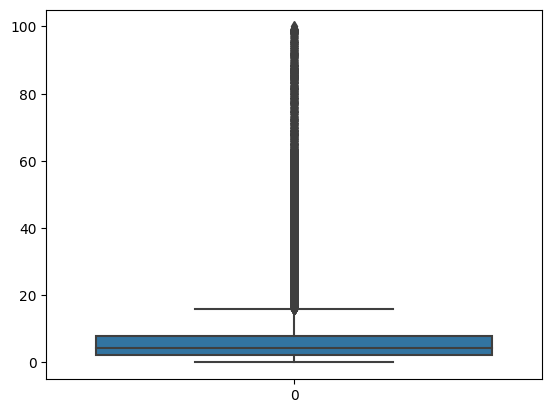

In [36]:
sns.boxplot(vm_long['avg cpu'])

In [37]:
(vm_long['avg cpu'] > 18).sum()

18636

In [1]:
from src.dataset import TimeSeriesDataset

In [2]:
data = TimeSeriesDataset(12, 1, file_count = 2)

Processing VM table...
Processing CPU reading files...


  0%|          | 0/2 [00:00<?, ?it/s]/home/lsh950919/cloud/src/dataset.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['vm id'] = filtered['vm id'].map(self.vm_ind)
 50%|█████     | 1/2 [00:16<00:16, 16.08s/it]/home/lsh950919/cloud/src/dataset.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['vm id'] = filtered['vm id'].map(self.vm_ind)
100%|██████████| 2/2 [00:34<00:00, 17.46s/it]


In [3]:
from torch.utils.data import DataLoader

In [4]:
a = DataLoader(data, batch_size = 1024, shuffle = True)

In [5]:
data.vm_table

,vm id,subscription id,deployment id,vm category,vm virtual core count,vm memory (gb)
0,0,0,0,0,0,0
1,2,2,2,1,1,2
2,3,1,3,1,0,1
3,4,2,2,1,1,2
4,5,2,2,1,1,2
...,...,...,...,...,...,...
135357,229296,5666,18985,0,3,4
135358,229297,5666,18985,0,3,4
135359,229298,5667,18987,1,3,4
135360,229299,5667,18987,0,3,4


In [5]:
next(iter(a))

KeyError: 46911

In [9]:
vm.shape, cpu.shape, cpu_label.shape

(torch.Size([1024, 6]), torch.Size([1024, 21, 12]), torch.Size([1024, 21, 1]))

In [9]:
228466 in data.vm_table['vm id'].unique()

True

In [10]:
228466 in data.cpu_data.keys()

False

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
vm_table = pd.read_csv('/home/lsh950919/cloud/data/vmtable.csv')
VM_COLUMNS = [content.split(',')[2] for content in open('/home/lsh950919/cloud/data/schema.csv').readlines() if content.startswith('vmtable')]
CPU_COLUMNS = [content.split(',')[2] for content in open('/home/lsh950919/cloud/data/schema.csv').readlines() if content.startswith('vm_cpu_readings')]
vm_table.columns = VM_COLUMNS
vm_ids = vm_table['vm id']

train_ids, val_ids = train_test_split(vm_ids, test_size = 0.2)
val_ids, test_ids = train_test_split(val_ids, test_size = 0.5)

In [4]:
train_ids

1119861    lzl9F4kfU/3/Kppd+qQ+eXNe5z0svgIIaOR3gvdd7uIcIQ...
1247625    0a2+Jzax3qOhDjPRV2NfXpnG+HyE+uoaeWdPCOqAC1zawW...
1655402    bkD30/nFc6smM5gHsBuWE0GgCaGZvt6ls8MzhoHapf9sow...
1763697    G2Ntrjr68TcyGtC0mIBZc5Ok1GS/nEnqp1Xt+73aOZOvwL...
1938848    8Pd+pyV3zJBG8oclPLbBKa0P1Q/vCTey9ueWEoWn0CfHG6...
                                 ...                        
385928     DVnjbOjeTw6YjtGzv2rQoTfpPVWjGOQjojR9shS3xne6DP...
1516387    baRWo7jhvv58fp5yqNOkz0rra2YElInSpjbgqmTfjxvf2s...
2010501    fjRO3hXMuA4UqQZiy1GFAtGGplupwyGe6IkxGzOWijCsKI...
683165     zlXIFJILhLDr40vQt44Mde7777mBtam/hjtSaAFNmuLtXN...
941197     IRMYn3NoD9X46XqfNbMr8f3pNNLI7MeUAAm/2CVVUHrWhO...
Name: vm id, Length: 1611012, dtype: object

In [1]:
with open('./data/links.txt', 'r') as file:
    links = file.readlines()
numbers = [5, 6, 7, 13, 23, 24, 26, 36, 41, 42, 43, 48]
    

In [4]:
[f'https://azurecloudpublicdataset.blob.core.windows.net/azurepublicdataset/trace_data/vm_cpu_readings/vm_cpu_readings-file-{number}-of-125.csv.gz\n' for number in numbers]

['https://azurecloudpublicdataset.blob.core.windows.net/azurepublicdataset/trace_data/vm_cpu_readings/vm_cpu_readings-file-5-of-125.csv.gz\n',
 'https://azurecloudpublicdataset.blob.core.windows.net/azurepublicdataset/trace_data/vm_cpu_readings/vm_cpu_readings-file-6-of-125.csv.gz\n',
 'https://azurecloudpublicdataset.blob.core.windows.net/azurepublicdataset/trace_data/vm_cpu_readings/vm_cpu_readings-file-7-of-125.csv.gz\n',
 'https://azurecloudpublicdataset.blob.core.windows.net/azurepublicdataset/trace_data/vm_cpu_readings/vm_cpu_readings-file-13-of-125.csv.gz\n',
 'https://azurecloudpublicdataset.blob.core.windows.net/azurepublicdataset/trace_data/vm_cpu_readings/vm_cpu_readings-file-23-of-125.csv.gz\n',
 'https://azurecloudpublicdataset.blob.core.windows.net/azurepublicdataset/trace_data/vm_cpu_readings/vm_cpu_readings-file-24-of-125.csv.gz\n',
 'https://azurecloudpublicdataset.blob.core.windows.net/azurepublicdataset/trace_data/vm_cpu_readings/vm_cpu_readings-file-26-of-125.csv.gz

In [ ]:
def download(url, path = '/scratch/lhk/cpu_readings'):
    file_name = os.path.basename(url)
    print('Downloading:', file_name)
    os.system(f"wget -P {path} {url}")
    os.system(f"gunzip {path}/{file_name}")

def unzip(filename):
    os.system(f'gunzip {filename}')

def split(file_path, train_ids, val_ids, test_ids):
    filename = os.path.basename(file_path)
    print(f'Splitting {filename}')
    filename, extension = filename.split('.')
    df = pd.read_csv(file_path)
    df.columns = CPU_COLUMNS
    
    train_df = df[df['vm id'].isin(train_ids)]
    val_df = df[df['vm id'].isin(val_ids)]
    test_df = df[df['vm id'].isin(test_ids)]

    train_df.to_csv(f'/scratch/lhk/cpu_readings/train/{filename}-train.{extension}', index = False)
    val_df.to_csv(f'/scratch/lhk/cpu_readings/val/{filename}-val{extension}', index = False)
    test_df.to_csv(f'/scratch/lhk/cpu_readings/test/{filename}-test.{extension}', index = False)

    os.remove(file_path)

In [ ]:
cpus = cpu_count()
pool = Pool(cpus)
for url in tqdm(links):
    pool.apply_async(download, args = (url, ))
pool.close()
pool.join()

cpu_reading_paths = glob('/scratch/lhk/cpu_readings/vm_cpu_readings*.csv')
vm_table = pd.read_csv('/home/lsh950919/cloud/data/vmtable.csv')
VM_COLUMNS = [content.split(',')[2] for content in open('/home/lsh950919/cloud/data/schema.csv').readlines() if content.startswith('vmtable')]
CPU_COLUMNS = [content.split(',')[2] for content in open('/home/lsh950919/cloud/data/schema.csv').readlines() if content.startswith('vm_cpu_readings')]
vm_table.columns = VM_COLUMNS
vm_ids = vm_table['vm id']

train_ids, val_ids = train_test_split(vm_ids, test_size = 0.2)
val_ids, test_ids = train_test_split(val_ids, test_size = 0.5)

# import ipdb; ipdb.set_trace()
os.makedirs('/scratch/lhk/cpu_readings/train', exist_ok = True)
os.makedirs('/scratch/lhk/cpu_readings/val', exist_ok = True)
os.makedirs('/scratch/lhk/cpu_readings/test', exist_ok = True)

pool = Pool(cpus)
for file_path in tqdm(cpu_reading_paths):
    pool.apply_async(split, args = (file_path, train_ids, val_ids, test_ids))
pool.close()
pool.join()